### 使用 Kuramoto 模型模拟爆炸同步现象
ref: Gómez-Gardeñes, J., Gómez, S., Arenas, A., Moreno, Y.: Explosive synchronization transitions in scale-free networks. Phys. Rev. Lett. 106, 128701 (2011).

model: Kuramoto model

network: scale-free network

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import networkx as nx
from scipy.sparse import coo_matrix
from joblib import Parallel, delayed

In [43]:
# 演算法
@njit
def Heun(fun, x0, t, dt, *args):
    """
    使用 Heun 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程函数，形式为 fun(x, t, *args)
        x0: 上一个时间单位的状态变量 (numpy.ndarray)
        t: 当前时间
        dt: 时间步长
    return:
        x1 (numpy.ndarray): 下一个时间单位的状态变量
    """
    # 计算当前点的斜率
    k1 = fun(x0, t, *args)
    
    # 使用 Euler 法预测值
    x_pred = x0 + dt * k1
    
    # 在预测点上计算新的斜率
    k2 = fun(x_pred, t + dt, *args)
    
    # 加权平均斜率得到新的状态
    x0 += 0.5 * dt * (k1 + k2)
    return x0

# Kuramoto 模型
@njit
def kuramoto(vars, t, omega, c, pre_ids, post_ids):
    """
    Kuramoto 模型的微分方程。
    args:
        vars: 相位
        t: 当前时间
        omega: 自然频率
        A: 耦合强度矩阵
        c: 耦合强度
    """
    currents = c * np.sin(vars[pre_ids]- vars[post_ids])

    num_nodes = len(vars)
    
    I_couple = np.bincount(post_ids, weights=currents, minlength=num_nodes)

    dvars_dt = omega + I_couple

    return dvars_dt  

In [44]:
def order_parameter(vars):
    """
    计算系统的顺序参数。
    args:
        vars: 相位
    return:
        r (float): 顺序参数
    """
    N = len(vars)
    r = np.abs(np.sum(np.exp(1j * vars)) / N)
    return r

In [45]:
# k = 6    # 每个节点的初始连接数（形成规则环格）
# p = 0.0  # 重连概率（p越大，网络越随机）
# G = nx.watts_strogatz_graph(n, k, p)
# G = nx.erdos_renyi_graph(n, p)
# G = nx.random_graphs.barabasi_albert_graph(n, 2)

# A = nx.adjacency_matrix(G).tocoo() # 邻接矩阵(稀疏)
# post_ids = A.row
# pre_ids = A.col

In [46]:
# 运行
def net(c_list):

    n = 1000  # 节点数
    G = nx.barabasi_albert_graph(n, 3)
    A = nx.adjacency_matrix(G).tocoo() # 邻接矩阵(稀疏)
    post_ids = A.row
    pre_ids = A.col

    # 初始相位
    vars = np.random.uniform(-np.pi, np.pi, n)  

    # 自然频率
    # omega = np.random.uniform(-.5, .5, n)  
    omega = np.asarray(list(dict(G.degree()).values()))

    dt = 0.05

    r_list = []

    for c in c_list:

        t = 0.
        
        ### 初始化
        for i in range(1000_00):
            Heun(kuramoto, vars, t, dt, omega, c, pre_ids, post_ids)
            t += dt

        # vars_list = []
        r = 0.
        cal_n = 3000_00
        for i in range(cal_n):
            Heun(kuramoto, vars, t, dt, omega, c, pre_ids, post_ids)
            t += dt

            r += order_parameter(vars)/cal_n
            
            # vars_list.append(vars.copy())
        
        r_list.append(r)

    return r_list

In [47]:
c_list1 = np.arange(1.1, 1.62, 0.02)  # 耦合强度列表
c_list2 = np.arange(1.6, 1.08, -0.02)

In [48]:
# c_ = [1.6]
# net(c_)

In [49]:
results = Parallel(n_jobs=20)(delayed(net)(c_list) for c_list in [c_list1, c_list2])

In [50]:
r_list1, r_list2 = results

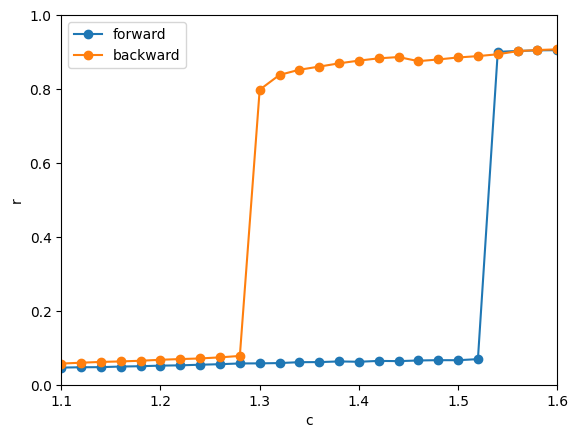

In [51]:
plt.plot(c_list1, r_list1, marker='o', label="forward")
plt.plot(c_list2, r_list2, marker='o', label="backward")

x = c_list1
y1 = r_list1
y2 = r_list2

plt.xlim(1.1, 1.6)
plt.ylim(0, 1)

plt.xlabel("c")
plt.ylabel("r")
plt.legend()

plt.show()

In [52]:
# # 处理相位变化
# Vars_list = np.asarray(vars_list)
# phase_list = Vars_list % (2 * np.pi)

In [53]:
# plt.plot(phase_list[:1000_00, :2])
# plt.show()